In [1]:
from gensim.models import Word2Vec
import gensim
#from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from numpy.linalg import svd
import numpy as np
from tqdm import tqdm

In [15]:
class SentenceIterator:
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, 'r') as f:
            for line in f:
                yield line.strip("\n").split(" ")

In [16]:
iterator_1 = SentenceIterator("../semeval2020_ulscd_swe/corpus1/lemma/kubhist2a.txt")
iterator_2 = SentenceIterator("../semeval2020_ulscd_swe/corpus2/lemma/kubhist2b.txt")

In [17]:
model_1 = gensim.models.Word2Vec(iterator_1, window=5)

In [18]:
model_1.save("../models/model_old.model")

In [21]:
model_2 = gensim.models.Word2Vec(iterator_2, window=5)

In [22]:
model_2.save("../models/model_new.model")

In [3]:
#Load the models here if you already have computed embeddings and saved the models
model_1 = Word2Vec.load("../models/model_old.model")
model_2 = Word2Vec.load("../models/model_new.model")

In [4]:
common_words = list(set(model_1.wv.key_to_index.keys()).intersection(set(model_2.wv.key_to_index.keys())))

In [6]:
# Align matrices using the orthogonal procrustes procedure
def align_matrices(A, B):
    u, sigma, vT = svd(np.matmul(A, B.transpose()), full_matrices=False)
    R = np.matmul(vT.transpose(), u.transpose())
    A_new = np.matmul(R, A)
    return A_new, B

def align_embeddings(emb_1, emb_2):
    emb1_new, _ = align_matrices(emb_1.transpose(),emb_2.transpose())
    return emb1_new.transpose(), emb_2

In [7]:
common_embs_1 = np.array([model_1.wv[word] for word in common_words])
common_embs_2 = np.array([model_2.wv[word] for word in common_words])

In [8]:
rotated_vectors, _ = align_embeddings(common_embs_1, common_embs_2)

In [9]:
emb_dict_1 = {}
emb_dict_2 = {}
for i, word in enumerate(common_words):
    emb_dict_1[word] = rotated_vectors[i]
    emb_dict_2[word] = common_embs_2[i]

In [10]:
similarities = {}
for word in common_words:
    similarities[word] = cosine_similarity(emb_dict_1[word].reshape(1,-1),emb_dict_2[word].reshape(1,-1))[0][0]

In [11]:
sorted_by_similarity = sorted(similarities.items(), key = lambda x : x[1])

In [12]:
sorted_by_similarity[-1]

('icke', 0.918219)

In [13]:
def compare_most_similar(model_1, model_2, word):
    most_similar_1 = model_1.wv.most_similar(word)
    most_similar_2 = model_2.wv.most_similar(word)
    print("\t Model 1 \t\tModel 2")
    for i in range(min(len(most_similar_1),len(most_similar_2))):
        print(f"{i}\t{most_similar_1[i][0]}: {most_similar_1[i][1]:.3f}\t\t{most_similar_2[i][0]}: {most_similar_2[i][1]:.3f}")

In [94]:
target_word = "politik"
compare_most_similar(model_1, model_2, target_word)

	 Model 1 		Model 2
0	grundsats: 0.832		utrikespolitik: 0.785
1	princip: 0.799		unionspolitik: 0.776
2	statsförfattning: 0.793		parlamentarism: 0.759
3	system: 0.787		taktik: 0.726
4	grundsattser: 0.764		radikalism: 0.718
5	äsigter: 0.761		chauvinism: 0.714
6	interesien: 0.752		organ: 0.712
7	syftning: 0.751		politisk: 0.710
8	lagstiftning: 0.749		präss: 0.706
9	politista: 0.749		press: 0.703


In [110]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans


In [171]:
def imagine(word, dimension):    
        
    most_similar_1 = model_1.wv.most_similar(word, topn=10)
    most_similar_1.append((target_word, 1.0))


    multi_dimens_list_1 = []
    for i in range(len(most_similar_1)):
        multi_dimens_list_1.append(model_1.wv[most_similar_1[i][0]])



    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=dimension, random_state=42)
    reduc_dim_list_1 = reducer.fit_transform(multi_dimens_list_1)


    #Clusters
    n_clusters = 5  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(reduc_dim_list_1)

    #2D
    if dimension == 2:

        plt.figure(figsize=(10, 8))
        #cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"
        for i, tuple in enumerate(most_similar_1):
            x, y= reduc_dim_list_1[i]
            cluster_label = labels[i]
            plt.scatter(x, y, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
            plt.text(x + 0.01, y + 0.01, tuple[0], fontsize=9)


        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")


    #3D
    elif dimension == 3:


        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"
        for i, tuple in enumerate(most_similar_1):
            x, y, z = reduc_dim_list_1[i]
            cluster_label = labels[i]
            ax.scatter(x, y, z, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
            ax.text(x + 0.01, y + 0.01, z + 0.01, tuple[0], fontsize=8)

        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")
        ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")


    
    plt.title(f"UMAP Visualization for word '{target_word}' and Similar Words")
    plt.tight_layout()
    plt.show()


# imagine(target_word, 2)
# imagine(target_word, 3)

In [170]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.9, n_components=2, random_state=42)
all_vectors = np.concatenate((common_embs_1,common_embs_2))
reduc_dim_mix = reducer.fit_transform(all_vectors)

/opt/anaconda3/envs/py310_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py310_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[[('grundsats', 0.8319324254989624), ('princip', 0.7986552715301514), ('statsförfattning', 0.7931532859802246), ('system', 0.7873449325561523), ('grundsattser', 0.7641224265098572), ('äsigter', 0.7606993913650513), ('interesien', 0.7515010237693787), ('syftning', 0.750504732131958), ('lagstiftning', 0.7486491203308105), ('politista', 0.7485437393188477), ('styrelseform', 0.7454885244369507), ('politisk', 0.7400339841842651), ('diplomatik', 0.7353585958480835), ('handlingssätt', 0.7319211959838867), ('opinion', 0.7269363403320312), ('maxim', 0.7247471809387207), ('mening', 0.7219759225845337), ('statskonst', 0.7206623554229736), ('afsigtcr', 0.7128368020057678), ('moderation', 0.712132453918457), ('politik', 1.0)], [('utrikespolitik', 0.7845776081085205), ('unionspolitik', 0.776295006275177), ('parlamentarism', 0.7593430876731873), ('taktik', 0.7259656190872192), ('radikalism', 0.7183257341384888), ('chauvinism', 0.7143756151199341), ('organ', 0.7122426629066467), ('politisk', 0.7097922

/var/folders/wd/h4jx1455657f5t8_rr1v43rh0000gq/T/ipykernel_11063/2734814439.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"


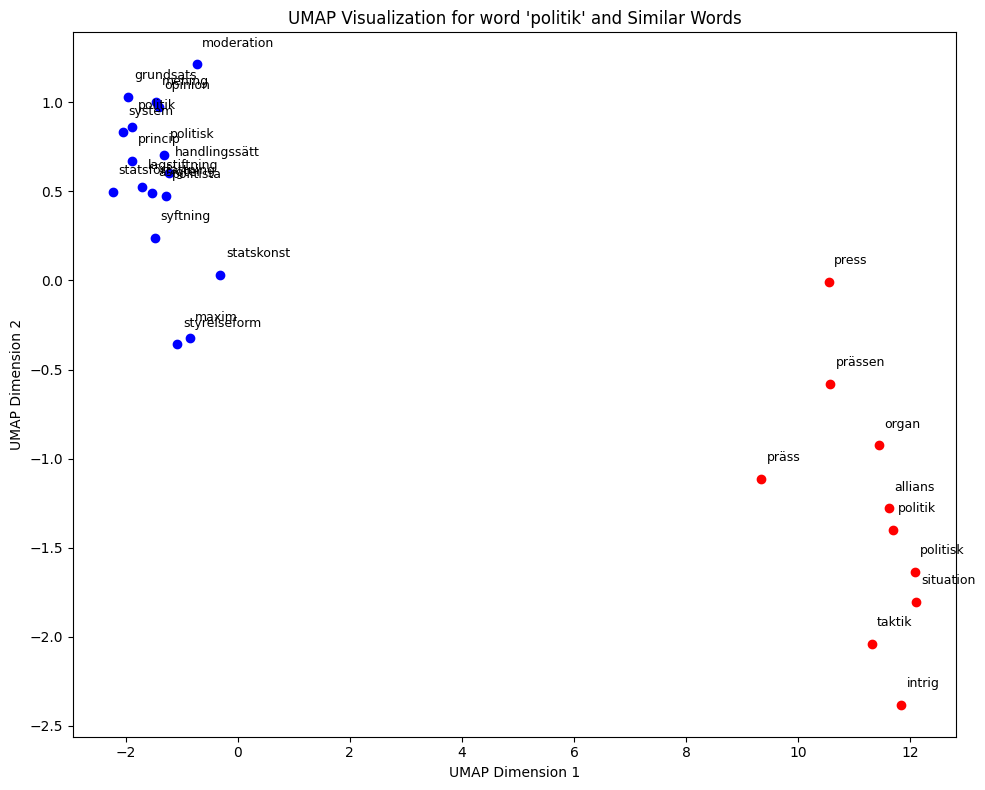

In [174]:
def imagine(word, dimension):    
        
    most_similar_1 = model_1.wv.most_similar(word, topn=20)
    most_similar_1.append((target_word, 1.0))

    most_similar_2 = model_2.wv.most_similar(word, topn=20)
    most_similar_2.append((target_word, 1.0))

    mix_similar = [most_similar_1, most_similar_2]
    print(mix_similar)

    multi_dimens_mix = []
    for d in range(len(mix_similar)):
        multi_dimens_mix.append([])
        for i in range(len(mix_similar[d])):
            multi_dimens_mix[d].append(model_1.wv[most_similar_1[i][0]])


    # reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=dimension, random_state=42)
    #reduc_dim_mix = reducer.fit_transform(multi_dimens_mix[0]+multi_dimens_mix[1])

    # all_vectors = np.concatenate((common_embs_1,common_embs_2))
    # reduc_dim_mix = reducer.fit_transform(all_vectors)
    reduced_dict_1 = {}
    reduced_dict_2 = {}
    for i, w in enumerate(common_words):
        reduced_dict_1[w] = reduc_dim_mix[i]
        reduced_dict_2[w] = reduc_dim_mix[i+len(reduc_dim_mix)//2]

    reduc_dim_mix_dbl = [reduc_dim_mix[:11],reduc_dim_mix[11:]]

    if "grundsattser" in reduced_dict_1:
        print("yes")
    #Clusters
    # n_clusters = 5  
    # kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # labels = kmeans.fit_predict(reduc_dim_list_1)

    #2D
    if dimension == 2:

        plt.figure(figsize=(10, 8))
        cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"
        for j, e in enumerate(mix_similar):
            for i, tuple in enumerate(e):
                #x, y = reduc_dim_list_1[i]
                #x, y = reduc_dim_mix_dbl[j][i]
                if j == 0:
                    try:
                        x, y = reduced_dict_1[tuple[0]]
                    except KeyError:
                        continue
                else:
                    try:
                        x, y = reduced_dict_2[tuple[0]]
                    except KeyError:
                        continue
                # cluster_label = labels[i]
                if j == 0:
                    plt.scatter(x, y, color='blue')
                else:
                    plt.scatter(x, y, color='red')

                #plt.scatter(x, y, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
                plt.text(x + 0.1, y + 0.1, tuple[0], fontsize=9)


        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        #plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")


    #3D
    elif dimension == 3:


        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        cmap = get_cmap("tab10") # Choose "tab10", "viridis", "plasma"
        for i, tuple in enumerate(most_similar_1):
            x, y, z = reduc_dim_list_1[i]
            cluster_label = labels[i]
            ax.scatter(x, y, z, color=cmap(cluster_label), label=f"Cluster {cluster_label}" if f"Cluster {cluster_label}" not in plt.gca().get_legend_handles_labels()[1] else None)
            ax.text(x + 0.01, y + 0.01, z + 0.01, tuple[0], fontsize=8)

        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")
        ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")


    
    plt.title(f"UMAP Visualization for word '{target_word}' and Similar Words")
    plt.tight_layout()
    plt.show()


imagine(target_word, 2)
# imagine(target_word, 3)

In [165]:
reduced

array([-0.14083008, -0.20930934,  0.8902618 ,  0.17766888, -0.4940379 ,
        0.20032199,  0.27467144,  0.04745303,  0.8204266 , -0.6232398 ,
        0.29780325,  0.38314173, -0.26404282, -0.44427177, -0.16187459,
        0.31406233, -0.0114156 ,  0.5946992 , -0.4103501 , -0.16365999,
       -0.03668376,  0.00722013,  0.09164137,  0.33069178, -0.1624936 ,
        0.3191231 ,  0.01927621,  0.5517698 , -0.2319205 , -0.05455146,
        0.2377945 , -0.3089315 ,  0.91887456,  0.3389211 ,  0.49263322,
        0.0134864 ,  0.49927673, -0.18811691, -0.5926283 ,  0.23593664,
        0.25038362,  0.05616631, -0.22671132,  0.341393  ,  0.5658385 ,
       -0.29724178, -0.9388461 ,  0.39461383,  0.03928311,  0.0644972 ,
        1.2776223 ,  0.33877087, -0.902825  , -0.2906707 , -0.86736053,
        0.49228945,  1.219236  ,  0.39576995,  0.38463968,  0.37360394,
        0.20095602,  0.02759666, -0.06734325,  0.5542623 , -0.04348721,
       -0.55140436,  0.35771212, -0.28292024, -0.24558023, -0.80